In [12]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
class XRayDataset(Dataset):
    def __init__(self, file_path, img_dir, transform=None):
        self.df = pd.read_parquet(file_path)
        self.img_dir = img_dir
        self.transform = transform

        self.image_ids = self.df['image_id'].values
        self.labels = self.df.iloc[:, 1:].values.astype(float)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.image_ids[idx])
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)


        return image, label

In [6]:

base_path = '../data'


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_dataset = XRayDataset(f'{base_path}/test_df.parquet', f'{base_path}/images/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


model = models.vgg16() 
model.classifier[6] = nn.Linear(4096, 18)  

model.load_state_dict(torch.load("vgg16_lungscan_v1.pth", map_location="cpu"))
model.eval()

device = torch.device("cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_loss = 0.0
correct_labels = 0
total_labels = 0

all_preds = []
all_targets = []



In [8]:
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.sigmoid(outputs)
        predicted_labels = (preds > 0.5).float()

        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.numel()

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

test_acc = 100 * correct_labels / total_labels
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


Evaluating: 100%|██████████| 349/349 [17:27<00:00,  3.00s/it]

Test Loss: 0.2115
Test Accuracy: 88.29%


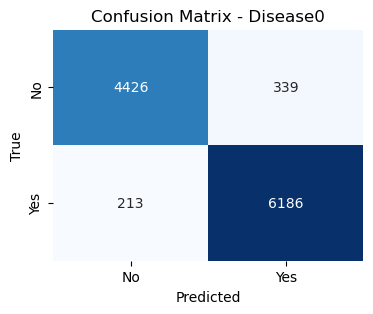

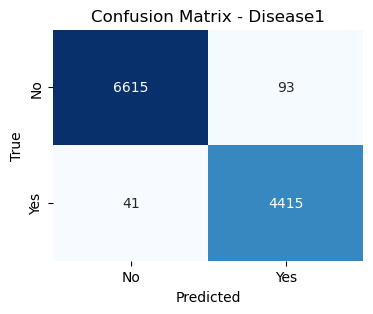

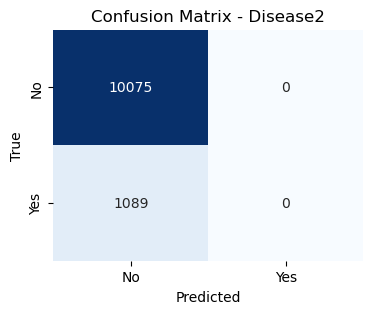

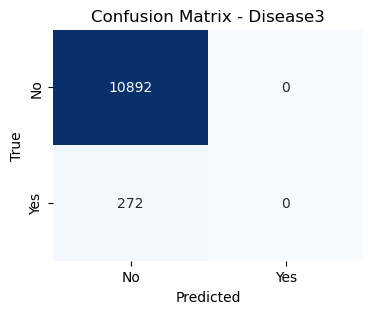

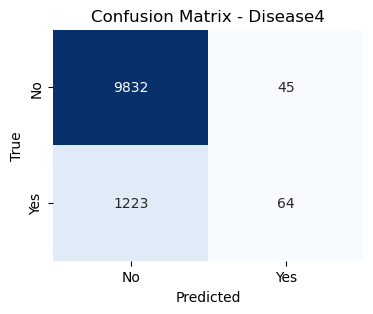

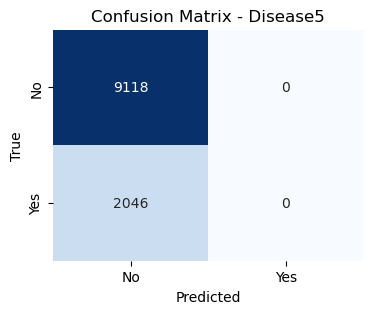

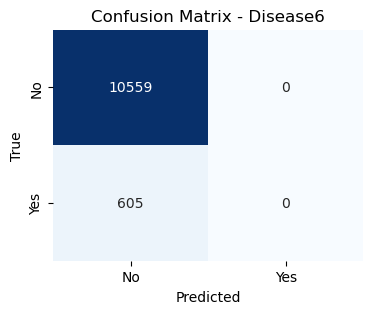

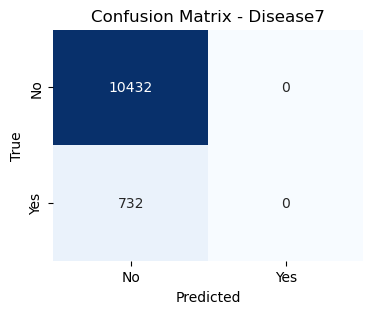

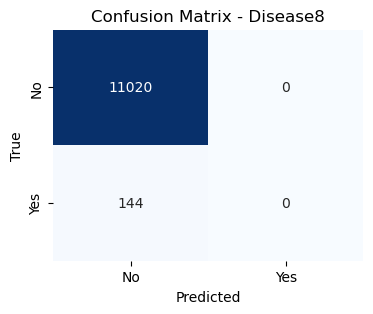

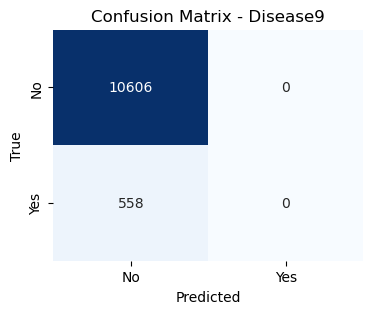

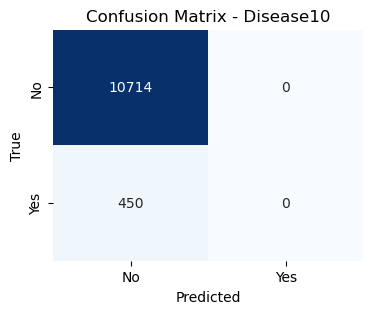

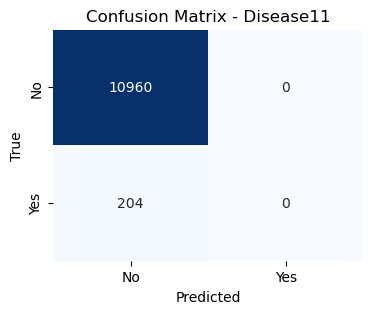

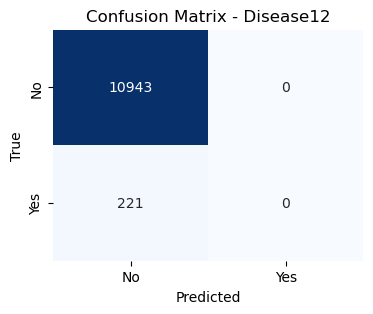

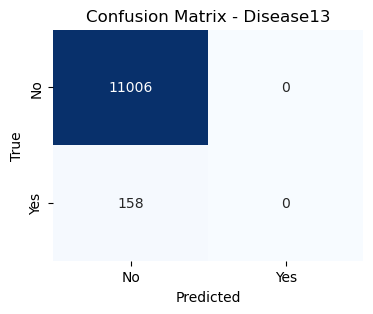

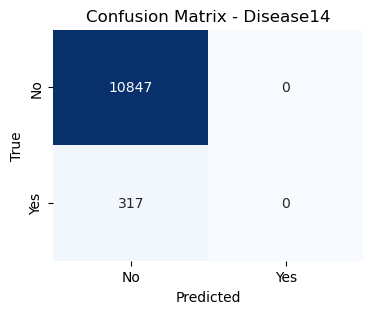

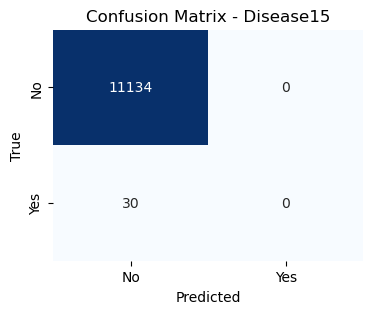

In [13]:
binary_preds = (all_preds > 0.5).astype(int)

disease_names = [f"Disease{i}" for i in range(16)] 

for i, disease in enumerate(disease_names):
    cm = confusion_matrix(all_targets[:, i], binary_preds[:, i])
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {disease}")
    plt.show()


In [ ]:
# The model does not make predictions for all diseases, it simply chooses not to because it's the most rewarding option in rare diseases to use only 0.
# We need to adjust the threshold to get better results. The threshold of 0.3 is a good starting point, which we will use in the next model. 
# Another thing to consider are weights for diseases, as some of them are more common than others, which skews the results even more.
# We also don't want to use patient's age and patient's gender as features, but use them to support the model in making predictions